In [1]:
import numpy as np
from torch import nn
import torch
from torchvision import transforms
import pickle
from inference import get_model_sar
from dataset import FloodSampleSARDataset
from torch.utils.data import DataLoader
from time import time
from loss import InvariantBCELoss
import matplotlib.pyplot as plt

In [ ]:
# Can do two ways:
# Analyze shift by tile or by patch
# For easiest way start with patch (make prediction over all patches in test set)

# Get Model

In [2]:
device = ("cuda"
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
         )
print(device)

cuda


In [3]:
# shifted model
n_channels = 7
channels = [True] * 7
config = {
    'name': 'unet++',
    'dropout': 0.0531091802785671,
    'deep_supervision': True,
    'autodespeckler': None,
    'channels': channels,
    'size': 68,
    'window': 64
}

In [26]:
shifted_model = get_model_sar(config, n_channels, load_model_path="./models/sar_unet++_model78.pth", device='cuda')
# for all 10 models
# paths = [f"./models/sar_unet++_model{i}.pth" for i in range(75, 85)]

In [4]:
# shifted + flipped model
flip_model = get_model_sar(config, n_channels, load_model_path="./models/sar_unet++_model132.pth", device='cuda')

### By Patch

In [5]:
sample_dir = f'data/sar/minibatch/raw/samples_68_1000/'
# load in mean and std
b_channels = sum(channels[-2:])
with open(f'data/sar/stats/minibatch_raw_68_1000.pkl', 'rb') as f:
    train_mean, train_std = pickle.load(f)

    train_mean = torch.from_numpy(train_mean[channels])
    train_std = torch.from_numpy(train_std[channels])
    # make sure binary channels are 0 mean and 1 std
    if b_channels > 0:
        train_mean[-b_channels:] = 0
        train_std[-b_channels:] = 1

# need to make sure normalize here works as intended
standardize = transforms.Compose([transforms.Normalize(train_mean, train_std)])
train_set = FloodSampleSARDataset(sample_dir, channels=config['channels'], typ="train", transform=standardize)
val_set = FloodSampleSARDataset(sample_dir, channels=config['channels'], typ="val", transform=standardize)
test_set = FloodSampleSARDataset(sample_dir, channels=config['channels'], typ="test", transform=standardize)

In [27]:
train_loader = DataLoader(train_set,
                        batch_size=256,
                        num_workers=10,
                        persistent_workers=True,
                        pin_memory=True,
                        shuffle=True,
                        drop_last=False)

In [6]:
val_loader = DataLoader(val_set,
                        batch_size=256,
                        num_workers=10,
                        persistent_workers=True,
                        pin_memory=True,
                        shuffle=True,
                        drop_last=False)

In [7]:
test_loader = DataLoader(test_set,
                        batch_size=256,
                        num_workers=10,
                        persistent_workers=True,
                        pin_memory=True,
                        shuffle=True,
                        drop_last=False)

In [8]:
center_1 = (config['size'] - config['window']) // 2
center_2 = center_1 + config['window']
c = (center_1, center_2)

In [9]:
# just use BCELoss for loss_fn
def get_best_shift(inputs, targets, loss_fn, device='cpu'):   
    """Return 5x5 numpy array with counts from the batch."""
    shift1 = targets.shape[-2] - inputs.shape[-2] + 1 # 5
    shift2 = targets.shape[-1] - inputs.shape[-1] + 1 # 5
    
    # issue of label being all zeros OR ones??? mask out all those patches where label is zeros or all ones
    # Create a mask where each row that is not all zeros is True
    mask1 = ~(targets == 0).all(axis=(1, 2, 3))
    mask2 = ~(targets == 1).all(axis=(1, 2, 3))
    combined_mask = mask1 & mask2
    # Use the mask to filter out the rows that are all zeros
    filtered_inputs = inputs[combined_mask]
    filtered_targets = targets[combined_mask]

    # calculate all potential shifts
    patch_shift_err = torch.empty((filtered_inputs.shape[0], shift1 * shift2), dtype=torch.float32, device=device)
    for i in range(shift1):
        for j in range(shift2):
            window = filtered_targets[:, :, i:i+inputs.shape[-2], j:j+inputs.shape[-1]]
            patch_shift_err[:, i * shift2 + j] = loss_fn(filtered_inputs, window)

    # we want to get counts for the shifts from patch_shift_err of a whole batch
    min_idx = torch.argmin(patch_shift_err, dim=1) # an array of indices, want to count them up

    # convert to numpy
    min_idx = min_idx.to('cpu').numpy()
    shift_count = np.bincount(min_idx, minlength=shift1 * shift2).reshape((shift1, shift2))

    return shift_count

In [10]:
# Do a heatmap of the 5x5 shift boxes!!!
def get_shift_count(loader, model, device):
    loss_fn = InvariantBCELoss()
    shift_count = np.zeros((5, 5), dtype=np.int32)
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)
            X_c = X[:, :, c[0]:c[1], c[0]:c[1]]
            logits = model(X_c)
            batch_shift_count = get_best_shift(logits, y.float(), loss_fn, device=device)
    
            shift_count = shift_count + batch_shift_count

    return shift_count

### Shifted Model

In [31]:
train_shift = get_shift_count(train_loader, shifted_model, device)

In [32]:
train_shift

array([[ 9120,  1992,  2132,  2392,  4480],
       [ 1782,   364,   659,   831,  1750],
       [ 2043,   819,  2015,  5666,  7843],
       [ 2198,  1373, 21209, 46360, 67980],
       [ 3451,  2001,  9876, 15641, 14149]])

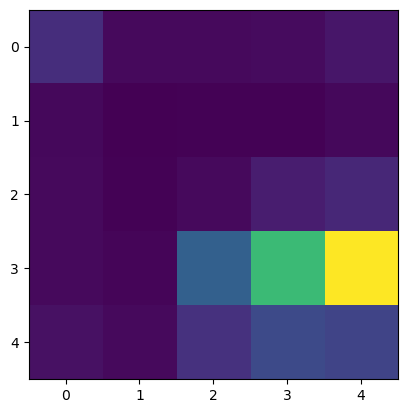

In [33]:
plt.imshow(train_shift)

In [35]:
val_shift = get_shift_count(val_loader, shifted_model, device)

In [36]:
val_shift

array([[1048,  184,  187,  198,  489],
       [ 210,   33,   52,   53,  132],
       [ 216,   73,  164,  608, 1038],
       [ 236,  122, 1884, 7243, 9238],
       [ 475,  154, 1219, 1440, 1570]])

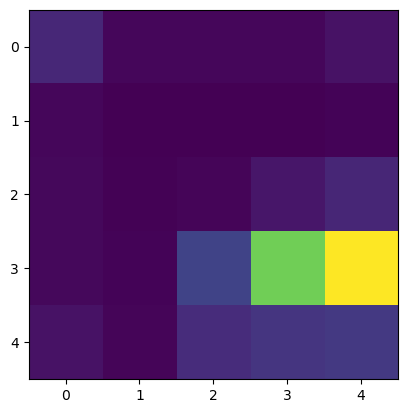

In [37]:
plt.imshow(val_shift)

In [39]:
test_shift = get_shift_count(test_loader, shifted_model, device)

In [40]:
test_shift

array([[1193,  198,  211,  256,  515],
       [ 221,   44,   59,   80,  224],
       [ 298,  107,  247,  693,  968],
       [ 208,  151, 2087, 6684, 9710],
       [ 601,  203, 1256, 1595, 1780]])

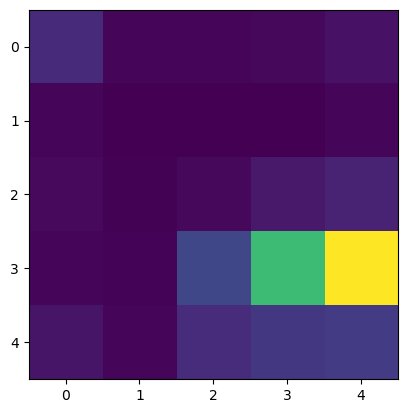

In [41]:
plt.imshow(test_shift)

### Shift + Flipping Model

In [42]:
f_train_shift = get_shift_count(train_loader, flip_model, device)

In [43]:
f_train_shift

array([[ 9745,  2028,  2199,  2317,  5225],
       [ 1930,   414,   921,   869,  2225],
       [ 2085,   735,  1696,  5403, 16983],
       [ 2262,  1277,  6150, 20978, 84643],
       [ 4148,  1819, 20481, 14427, 17166]])

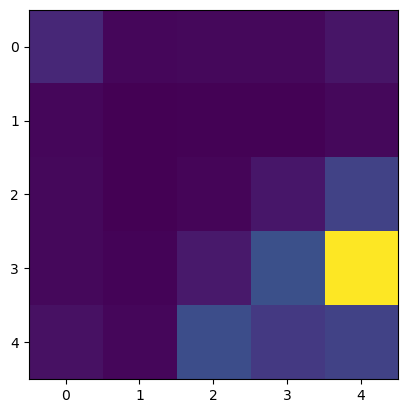

In [44]:
plt.imshow(f_train_shift)

In [11]:
f_val_shift = get_shift_count(val_loader, flip_model, device)

In [12]:
f_val_shift

array([[ 1062,   201,   211,   198,   611],
       [  253,    48,    61,    99,   242],
       [  183,    38,   137,   584,  2223],
       [  180,    83,   479,  2736, 12335],
       [  511,   173,  2417,  1076,  2125]])

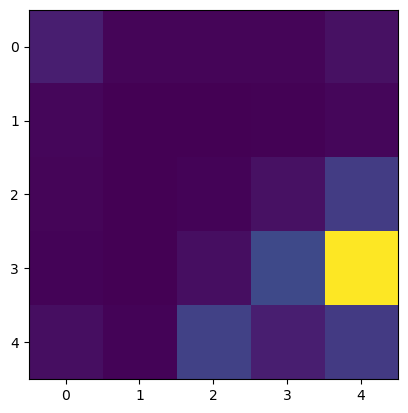

In [14]:
plt.imshow(f_val_shift)

In [15]:
f_test_shift = get_shift_count(test_loader, flip_model, device)

In [16]:
f_test_shift

array([[ 1187,   211,   219,   224,   612],
       [  242,    34,    33,    61,   300],
       [  303,    82,   139,   622,  1922],
       [  230,    97,   960,  2206, 13080],
       [  623,   232,  1882,  1656,  2432]])

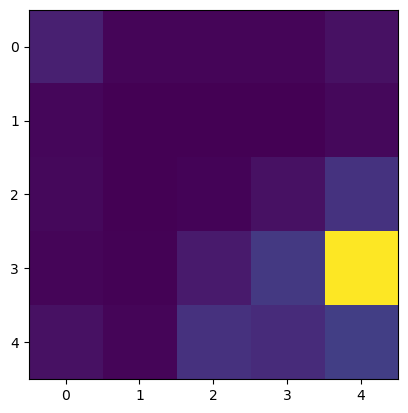

In [17]:
plt.imshow(f_test_shift)

### By Tile

In [6]:
# from inference import sample_one_sar
from utils import SARChannelIndexer
from glob import glob
import re
import rasterio

For each of the 400+ tiles in the dataset, make prediction using our model and calculate the shift direction of prediction vs. true label.

In [7]:
# first compile list of directory paths to appropriate files
def get_all_tiles(sample_dir='../sampling/samples_200_6_4_10_sar/'):
    """Get list of all tile files"""
    lst = []
    all_events = glob(sample_dir + '[0-9]*')
    p1 = re.compile('\d{8}_\d+_\d+')
    p2 = re.compile('pred_(\d{8})_.+.tif')
    p3 = re.compile('sar_\d{8}_(\d{8})_.+.tif')
    for event in all_events:
        m1 = p1.search(event)

        if m1:
            eid = m1.group(0)
        else:
            print(f'No matching eid. Skipping {event}...')
            continue

        # search for label file + sar file
        # look for labels w tci + sar pairings
        for label in glob(event + f'/pred_*.tif'):
            m2 = p2.search(label)
            img_dt = m2.group(1)
            
            sar_vv_files = glob(event + f'/sar_{img_dt}_*_vv.tif')
            if len(sar_vv_files) == 0:
                # SKIP IF SAR NOT FOUND FOR A LABEL (THIS IS SOMETIMES POSSIBLE)
                print(f'SAR file not found for label {label}')
                continue 
            else:
                # found a tile - collect files for processing
                m3 = p3.search(sar_vv_files[0])
                dir_path = sample_dir + eid
                s2_dt = img_dt
                s1_dt = m3.group(1)
                lst.append((dir_path, s2_dt, s1_dt, eid, label))

    return lst

def get_pred_logits(size, model, channels, standardize, train_mean, dir_path, s2_dt, s1_dt, eid, device='cpu'):
    layers = []
    my_channels = SARChannelIndexer(channels)
    if my_channels.has_vv():
        vv_file = dir_path + f'/sar_{s2_dt}_{s1_dt}_{eid}_vv.tif'
        with rasterio.open(vv_file) as src:
            vv_raster = src.read()
        layers.append(vv_raster)
    if my_channels.has_vh():
        vh_file = dir_path + f'/sar_{s2_dt}_{s1_dt}_{eid}_vh.tif'
        with rasterio.open(vh_file) as src:
            vh_raster = src.read()
        layers.append(vh_raster)

    # need dem for slope regardless if in channels or not
    dem_file = dir_path + f'/dem_{eid}.tif'
    with rasterio.open(dem_file) as src:
        dem_raster = src.read().astype(np.float32)
    if my_channels.has_dem():
        layers.append(dem_raster)
        
    slope = np.gradient(dem_raster, axis=(1,2))
    slope_y_raster, slope_x_raster = slope
    if my_channels.has_slope_y():
        layers.append(slope_y_raster)
    if my_channels.has_slope_x():
        layers.append(slope_x_raster)
    if my_channels.has_waterbody():
        waterbody_file = dir_path + f'/waterbody_{eid}.tif'
        with rasterio.open(waterbody_file) as src:
            waterbody_raster = src.read().astype(np.float32)
        layers.append(waterbody_raster)
    if my_channels.has_roads():
        roads_file = dir_path + f'/roads_{eid}.tif'
        with rasterio.open(roads_file) as src:
            roads_raster = src.read().astype(np.float32)
        layers.append(roads_raster)

    X = np.vstack(layers, dtype=np.float32)

    # get missing values mask (to later zero out)
    missing_vals = X[0] == -9999
    
    # impute missing values in each channel with its mean
    train_mean = train_mean.tolist()
    for i, mean in enumerate(train_mean):
        X[i][missing_vals] = mean
        
    X = torch.from_numpy(X)
    X = standardize(X)

    # tile discretely and make predictions
    HEIGHT = X.shape[-2]
    WIDTH = X.shape[-1]
    label = torch.zeros((HEIGHT, WIDTH), dtype=torch.float32)

    # send to device
    X = X.to(device)
    
    i = 0
    while i * size < HEIGHT:
        j = 0
        while j * size < WIDTH:
            start_row = i * size
            start_col = j * size
            end_row = (i + 1) * size if (i + 1) * size <= HEIGHT else HEIGHT
            end_col = (j + 1) * size if (j + 1) * size <= WIDTH else WIDTH
            
            dh = end_row - start_row # normally size
            dw = end_col - start_col # normally size
            if dh < size:
                # boundary tile
                patch_row = start_row - size + dh
            else:
                patch_row = start_row

            if dw < size:
                patch_col = start_col - size + dw
            else:
                patch_col = start_col

            patch = X[:, patch_row : patch_row + size, patch_col : patch_col + size].unsqueeze(0)

            with torch.no_grad():
                patch_logits = model(patch) # .squeeze()
                
                # stitch tiles together and convert to numpy then use boolean mask
                # want H x W
                patch_pred = patch_logits.squeeze().to('cpu')
                label[start_row : end_row, start_col : end_col] = patch_pred[size - dh:, size - dw:]
            j += 1
        i += 1

    label[missing_vals] = 0
    return label

def get_best_tile_shift(pred, label, loss_fn, shift_size=2):
    """Takes label and pred torch tensors and returns shift index with smallest BCE error.
    Assume also the tensors are (H x W) in shape."""
    # for 469 x 399 - subtract 2 on both sides
    # shrink pred to 465 x 395
    shift1 = shift_size * 2 + 1 
    shift2 = shift_size * 2 + 1
    shift_err = torch.empty((shift1 * shift2), dtype=torch.float32)
    inputs = pred[shift_size:-shift_size, shift_size:-shift_size]
    for i in range(shift1):
        for j in range(shift2):
            window = label[i:i+inputs.shape[0], j:j+inputs.shape[1]]
            shift_err[i * shift2 + j] = loss_fn(inputs, window)
    best_shift = shift_err.argmin().item()
    return best_shift // shift2, best_shift % shift2

In [8]:
lst = get_all_tiles(sample_dir='../sampling/samples_200_6_4_10_sar/')

SAR file not found for label ../sampling/samples_200_6_4_10_sar/20200812_378_746/pred_20200816_20200812_378_746.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_394_1102/pred_20190906_20190906_394_1102.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_394_1100/pred_20190906_20190906_394_1100.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_395_1099/pred_20190906_20190906_395_1099.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_393_1101/pred_20190906_20190906_393_1101.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_396_1100/pred_20190906_20190906_396_1100.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20180917_389_1098/pred_20180921_20180917_389_1098.tif
SAR file not found for label ../sampling/samples_200_6_4_10_sar/20190906_395_1102/pred_20190906_20190906_395_1102.tif
SAR file not found for label ../sampling/samples_200_6_4_1

In [9]:
# calculate shift for each tile
def get_tile_shift_count(model, channels, standardize, train_mean, lst):
    loss_fn = nn.BCEWithLogitsLoss()
    tile_shift_count = np.zeros((5, 5), dtype=np.int32)
    for dir_path, s2_dt, s1_dt, eid, label_path in lst:
        # get label
        with rasterio.open(label_path) as src:
            label_raster = src.read([1, 2, 3])
            # if label has any values != 0 or 255 then print to log!
            if np.any((label_raster > 0) & (label_raster < 255)):
                raise Exception(f'{label_file} values are not 0 or 255.')
                        
            label_binary = np.where(label_raster[0] != 0, 1, 0)
            label_binary = np.expand_dims(label_binary, axis = 0)
        
            HEIGHT = src.height
            WIDTH = src.width
    
        if not np.any(label_binary):
            print(f'Label {label_path} contains all zeros (no water) so we skip.')
            continue
            
        label = torch.from_numpy(label_binary).squeeze().to(torch.float32)
        # get prediction
        pred = get_pred_logits(64, model, channels, standardize, train_mean, 
                                dir_path, s2_dt, s1_dt, eid, device=device)
        # calculate shift direction
        # return shift direction
        i, j = get_best_tile_shift(pred, label, loss_fn)
        tile_shift_count[i, j] += 1

    return tile_shift_count

In [36]:
tile_shift_count

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   3,   4],
       [  0,   0,  45, 109, 208],
       [  0,   0,  17,  22,   5]], dtype=int32)

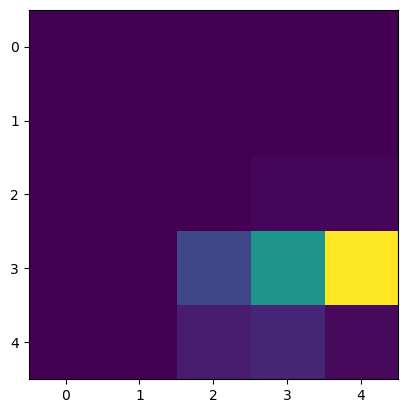

In [37]:
plt.imshow(tile_shift_count)

### Shift + Flipping Model

In [10]:
flip_tile_shift_count = get_tile_shift_count(flip_model, channels, standardize, train_mean, lst)

/home/dma/miniconda3/envs/floodmaps-training/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [12]:
flip_tile_shift_count

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   4,  11],
       [  0,   0,  10,  27, 283],
       [  2,   0,  39,  30,   7]], dtype=int32)

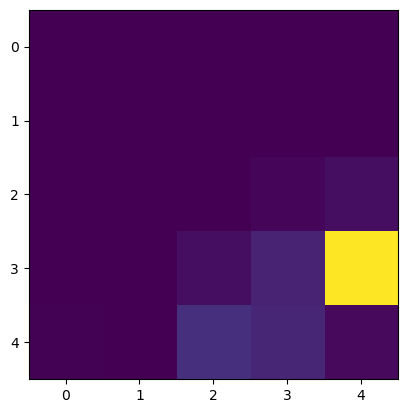

In [11]:
plt.imshow(flip_tile_shift_count)